## Policy Gradient: REINFORCE algorithm
REwarc Increment = Nonnegative Factor * Offset Reinforcement * Characteristic Eligibility

target funct:
$$
J(θ) = \mathbb{E}_{S_0}[V^{π_θ}(S_0)]
$$

derivative of the above:
$$
\begin{aligned}
∇_θJ(θ) &∝ \sum_{s \in S} v^{π_θ}(s) \sum_{a \in A} Q^{π_θ}(s, a)∇_θπ_θ(a | s) \\ 
  &= \sum_{s \in S} v^{π_θ}(s) \sum_{a \in A}π_θ(a | s) Q^{π_θ}(s, a)\frac{∇_θπ_θ(a | s)}{π_θ(a | s)} \\ 
  &= \mathbb{E}_{π_θ}[ Q^{π_θ}(s, a)∇_θ \logπ_θ(a | s)]
\end{aligned}
$$

MC sampling:
$$
J(θ) = \mathbb{E}_{π_0}[\sum_{t=0}^T(\sum_{t'=t}^Tγ^{t'-t}r_{t'})∇_θ \logπ_θ(a_t | s_t)]
$$

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.02876046, -0.02922363,  0.01167002, -0.03860232], dtype=float32)

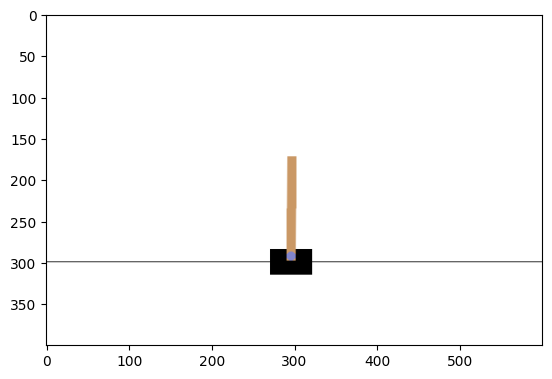

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [3]:
import torch

# 定义模型
model = torch.nn.Sequential(
  torch.nn.Linear(4, 128),
  torch.nn.ReLU(),
  torch.nn.Linear(128, 2),
  torch.nn.Softmax(dim=1),
)

model(torch.randn(2, 4))

tensor([[0.5691, 0.4309],
        [0.5040, 0.4960]], grad_fn=<SoftmaxBackward0>)

In [5]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 4)

  # [1, 4] -> [1, 2]
  prob = model(state)
  
  # 根据概率选择一个动作
  action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
  
  return action

get_action([1, 2, 3, 4])

0

In [7]:
# 得到一局游戏的数据
def get_data():
  states = []
  rewards = []
  actions = []
  
  # 初始化游戏
  state = env.reset()
  
  # 玩到游戏结束为止
  over = False
  while not over:
    # 根据当前状态得到一个动作
    action = get_action(state)
    
    # 执行动作，得到反馈
    next_state, reward, over, _ = env.step(action)
    
    # 记录数据样本
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    
    # 更新游戏状态，开始下一个动作
    state = next_state
    
  return states, rewards, actions

get_data()

([array([ 0.03561369,  0.02899127, -0.00988229,  0.04989661], dtype=float32),
  array([ 0.03619351,  0.22425352, -0.00888436, -0.2458878 ], dtype=float32),
  array([ 0.04067858,  0.02925958, -0.01380212,  0.04397959], dtype=float32),
  array([ 0.04126377,  0.2245767 , -0.01292252, -0.2530259 ], dtype=float32),
  array([ 0.04575531,  0.41988078, -0.01798304, -0.54975665], dtype=float32),
  array([ 0.05415292,  0.61525065, -0.02897817, -0.8480508 ], dtype=float32),
  array([ 0.06645793,  0.8107556 , -0.04593919, -1.1497035 ], dtype=float32),
  array([ 0.08267305,  0.6162624 , -0.06893326, -0.87177277], dtype=float32),
  array([ 0.09499829,  0.8122507 , -0.08636872, -1.1853074 ], dtype=float32),
  array([ 0.11124331,  1.00838   , -0.11007486, -1.5037658 ], dtype=float32),
  array([ 0.13141091,  0.8147527 , -0.14015017, -1.2473792 ], dtype=float32),
  array([ 0.14770597,  0.6216781 , -0.16509776, -1.0016763 ], dtype=float32),
  array([ 0.16013953,  0.42910084, -0.1851313 , -0.76505685], dt

In [9]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step(action)
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

22.0

In [13]:
def train():
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(1000):
    # 玩一局游戏，得到数据
    states, rewards, actions = get_data()
    
    optimizer.zero_grad()
    
    # 反馈和，初始化为0
    reward_sum = 0
    
    # 从最后一步开始算
    for i in reversed(range(len(states))):
      
      #反馈的和,从最后一步的反馈开始计算
      #每往前一步,>>和<<都衰减0.02,然后再加上当前步的反馈
      reward_sum *= 0.98
      reward_sum += rewards[i]
      
      #重新计算对应动作的概率
      state = torch.FloatTensor(states[i]).reshape(1, 4)
      # [1, 4] -> [1, 2]
      prob = model(state)
      # [1, 2] -> scalar
      prob = prob[0, actions[i]]
      
      # 根据求导公式
      loss = -prob.log() * reward_sum
      
      # 累计梯度
      loss.backward(retain_graph=True)
    
    optimizer.step()      
    
    if epoch % 100 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, test_result)
      
train()

0 133.5
100 124.3
200 104.1
300 129.7
400 193.6
500 192.4
600 198.6
700 200.0
800 193.2
900 197.2


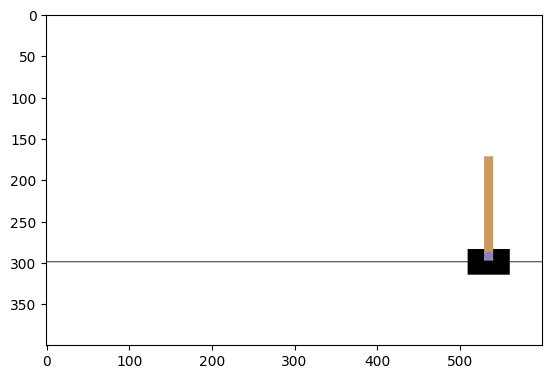

200.0

In [14]:
test(play=True)